# Water Allocation Simulation Analysis
This notebook provides tools to analyze the results of the water allocation simulation
across multiple scenarios, focusing on ecological and economic impacts under different
conditions.

## Overview
The simulation tests water allocation policies across various scenarios with different:
- River basins (station configurations)
- Actor compositions
- Water scarcity levels
- Forecast error profiles (bias and uncertainty)

The analysis evaluates how these factors affect both ecological integrity and economic benefits.


In this notebook we will:
1. Run the set of evaluation scenarios varying station size, scarcity level,  
   forecast bias and uncertainty.
2. Collect ecological and economic impact metrics for each run.
3. Visualize trade-offs and explore how model parameters influence outcomes.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from types import MethodType
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import src.scenarios as sc
import src.plot_multi_analysis as pma

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [2]:
def custom_quota(
    self,
    crisis_level: int,
    actors_priority: np.ndarray,
    avg_pump: np.ndarray,
    DOE: float,
    DCR: float,
) -> np.ndarray:
    """
    Soft quota policy that balances ecological concerns and economic needs.

    Ensures some access for all actors, scaled by priority and crisis level.
    """
    scaling_matrix = {
        -1: [1.0, 1.0, 1.0],  # Normal
         0: [0.8, 0.9, 1.0],  # Alert
         1: [0.5, 0.75, 1.0], # Crisis 1
         2: [0.3, 0.6, 1.0],  # Crisis 2
    }

    level = max(min(int(crisis_level), 2), -1)
    factors = np.array([scaling_matrix[level][int(p)] for p in actors_priority])
    
    # Ensure a small baseline quota for survival
    min_quota = 0.1 * avg_pump
    quota = np.maximum(avg_pump * factors, min_quota)
    return quota


In [3]:
def custom_incentive_policy(self,
                    actions: np.ndarray,
                    actors_priority: np.ndarray,
                    avg_incomes: np.ndarray,
                    water_pump: np.ndarray,
                    avg_pump: np.ndarray,
                    is_crisis: np.ndarray,
                    water_flows: np.ndarray,
                    quota: np.ndarray,
                    DOE=15,
                    DCR=10) -> np.ndarray:
    """
    Incentive policy encourages conservation while preserving economic value.
    """
    fine = np.zeros(self.nb_actors)
    stress = int(is_crisis[-1])

    avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)

    for i in range(self.nb_actors):
        overuse = max(0.0, water_pump[i] - quota[i])
        underuse = max(0.0, quota[i] - water_pump[i])

        recent_flow = water_flows[-1] if len(water_flows) > 0 else DOE
        ecol_stress = max(0.0, (DOE - recent_flow) / (DOE - DCR + 1e-6))
        stress_amp = 1 + 0.5 * stress

        if overuse > 0:
            base_fine = avg_incomes[i] * 0.2
            raw_fine = base_fine * (overuse / (avg_pump[i] + 1e-6)) * stress_amp
            max_fine = avg_incomes[i] * 0.3
            fine[i] = min(raw_fine, max_fine)

        elif underuse > 0 and ecol_stress > 0.1:
            fine[i] = -2.5 * ecol_stress * (underuse / (quota[i] + 1e-6))

        if int(actors_priority[i]) == 2:
            fine[i] = min(fine[i], 0.0)

    return fine


## Scenario Definition
Runs simulations across the pre-defined scenarios.
We iterate over:
- **Stations**: Tarn vs. La Vézère  
- **Scarcity levels**: low / medium / high  
- **2 set of actors and variant with heterogenous biaises and uncertainties**  
- **Forecast bias/uncertainty** settings  

Execute the next cell to proceed multo-scenario analysis.

In [4]:
if False:
    results_df = sc.run_all_scenarios(
        turns=700,
        iterations=5,
        custom_incentive_policy=custom_incentive_policy,
        custom_quota=custom_quota)
    results_df.to_csv('results_df_custom.csv', index=False)
else:
# load results_df from csv
    results_df = pd.read_csv('results_df_custom.csv')

In [5]:
results_df = pd.read_csv('results_df_custom.csv')
qualify_results_df = results_df[results_df["priority_ok"] == 1]
percent_qualifies = (len(qualify_results_df) / len(results_df)) * 100
print(f"Percent that qualifies: {percent_qualifies:.2f}%")

Percent that qualifies: 83.80%


In [6]:
print(qualify_results_df['ecological_impact'].median())
print(qualify_results_df['economic_impact'].median())

0.9556338028169014
0.9009633968228088



## Multi-Scenario Analysis


### Ecological vs. economic impact.

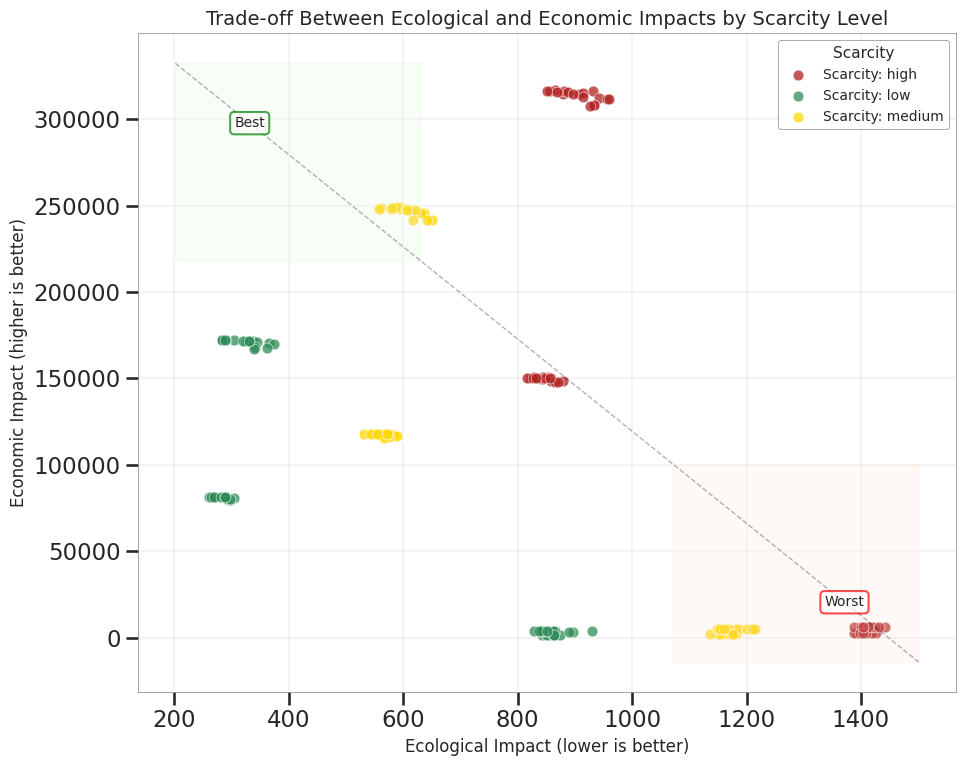

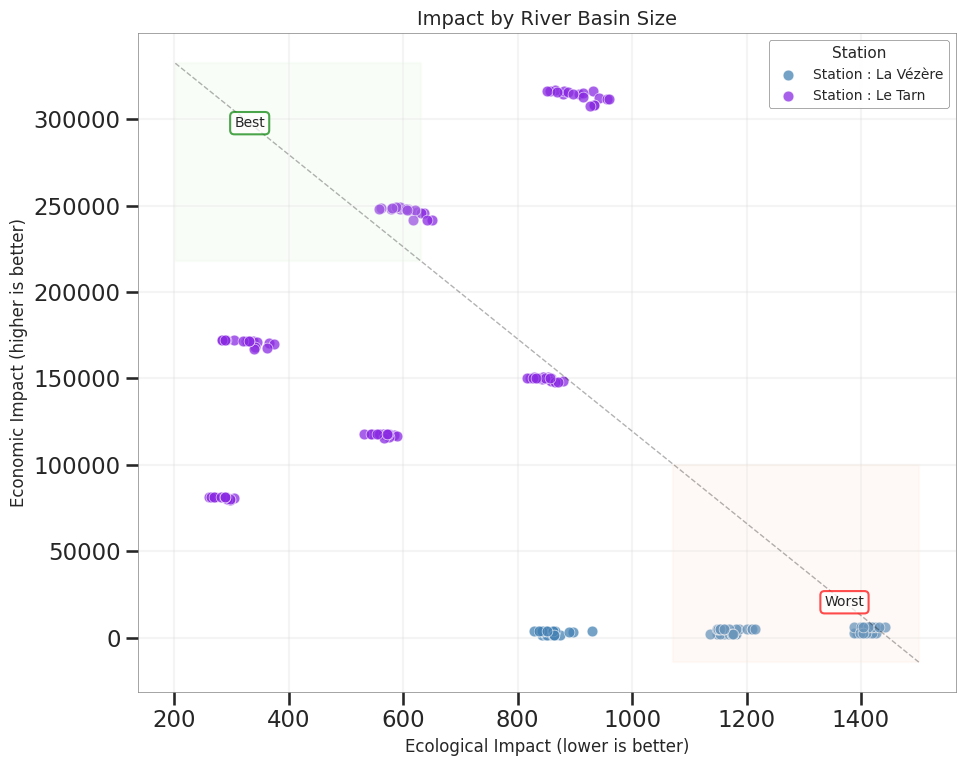

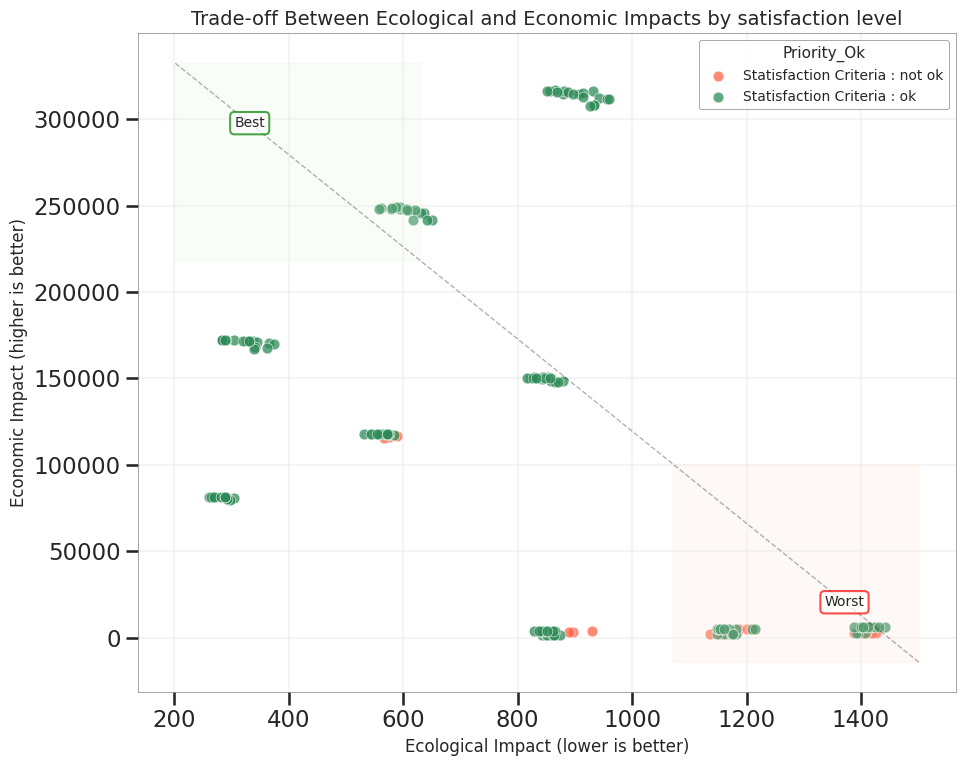

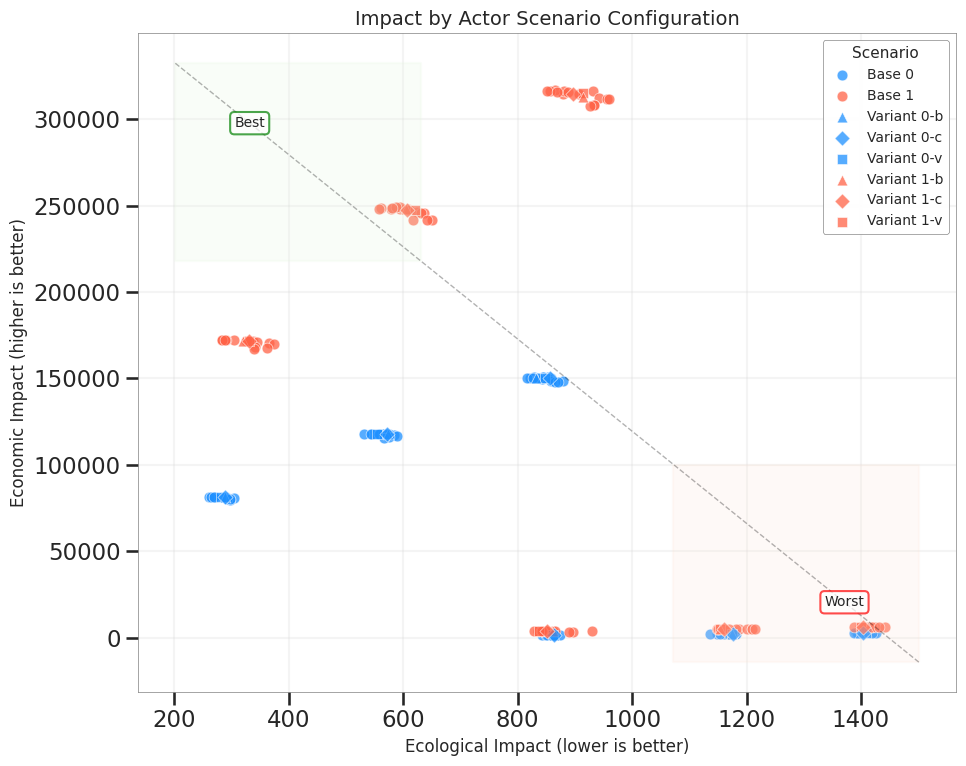

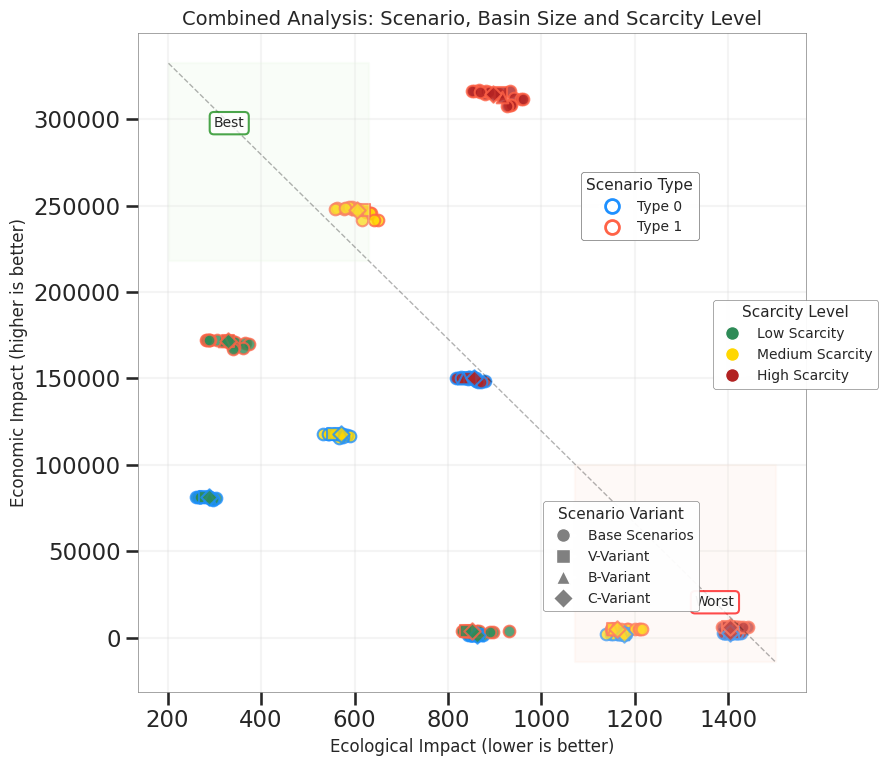

In [8]:
pma.analyze_scenario_impacts(results_df)

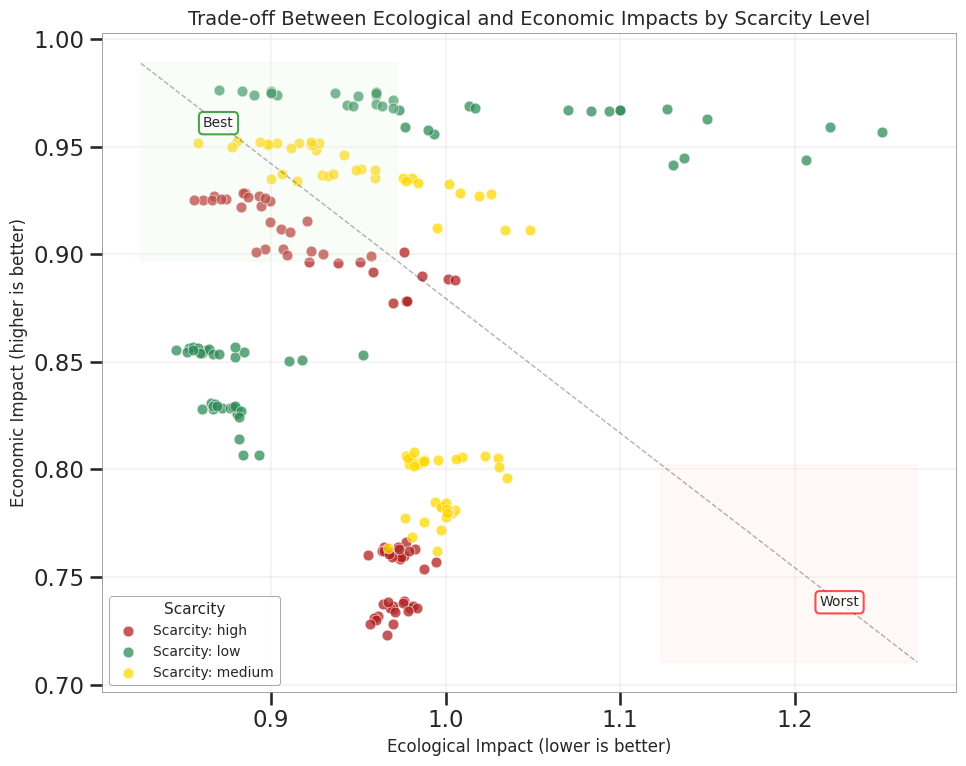

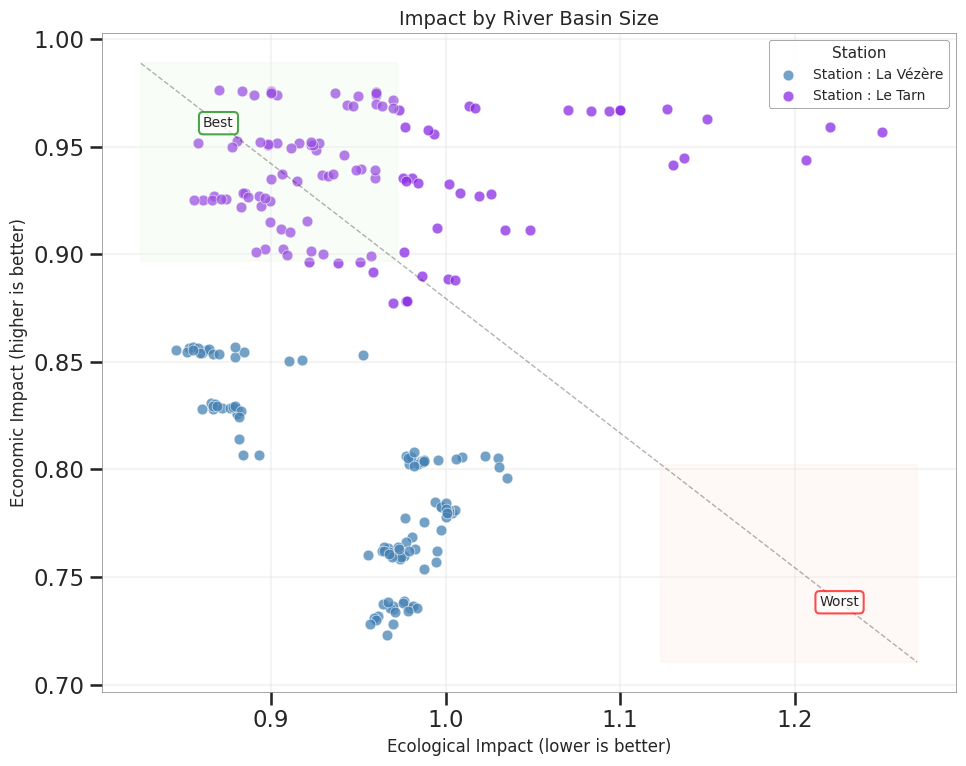

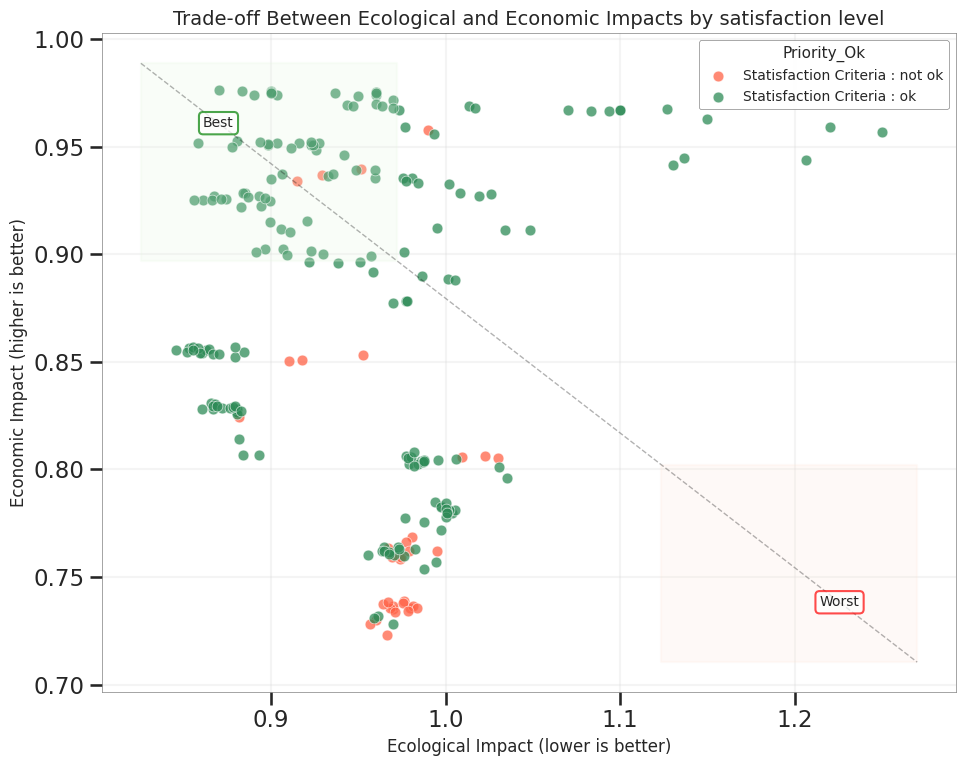

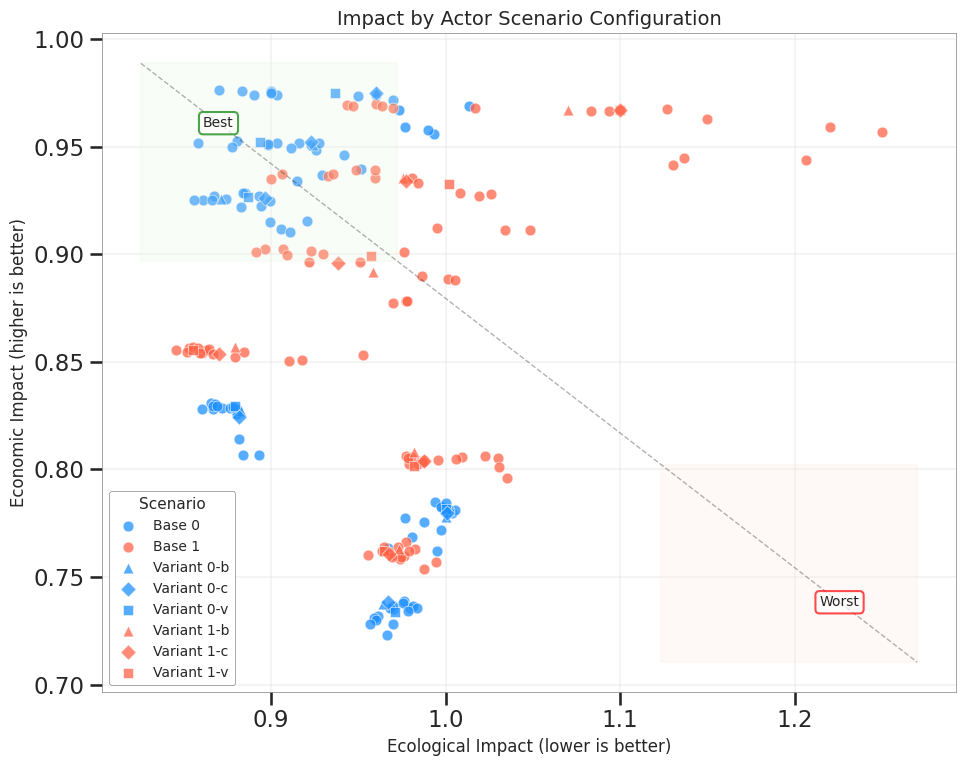

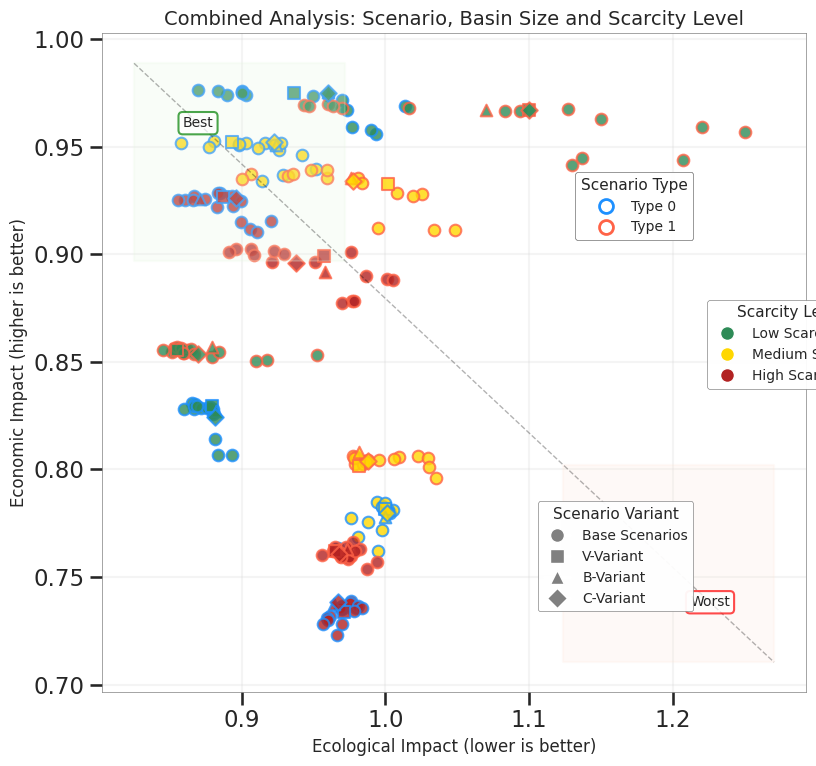

In [9]:
pma.analyze_scenario_impacts(results_df , is_scalled=True)

## Analyzing Forecast Bias & Uncertainty & Scarcity levels

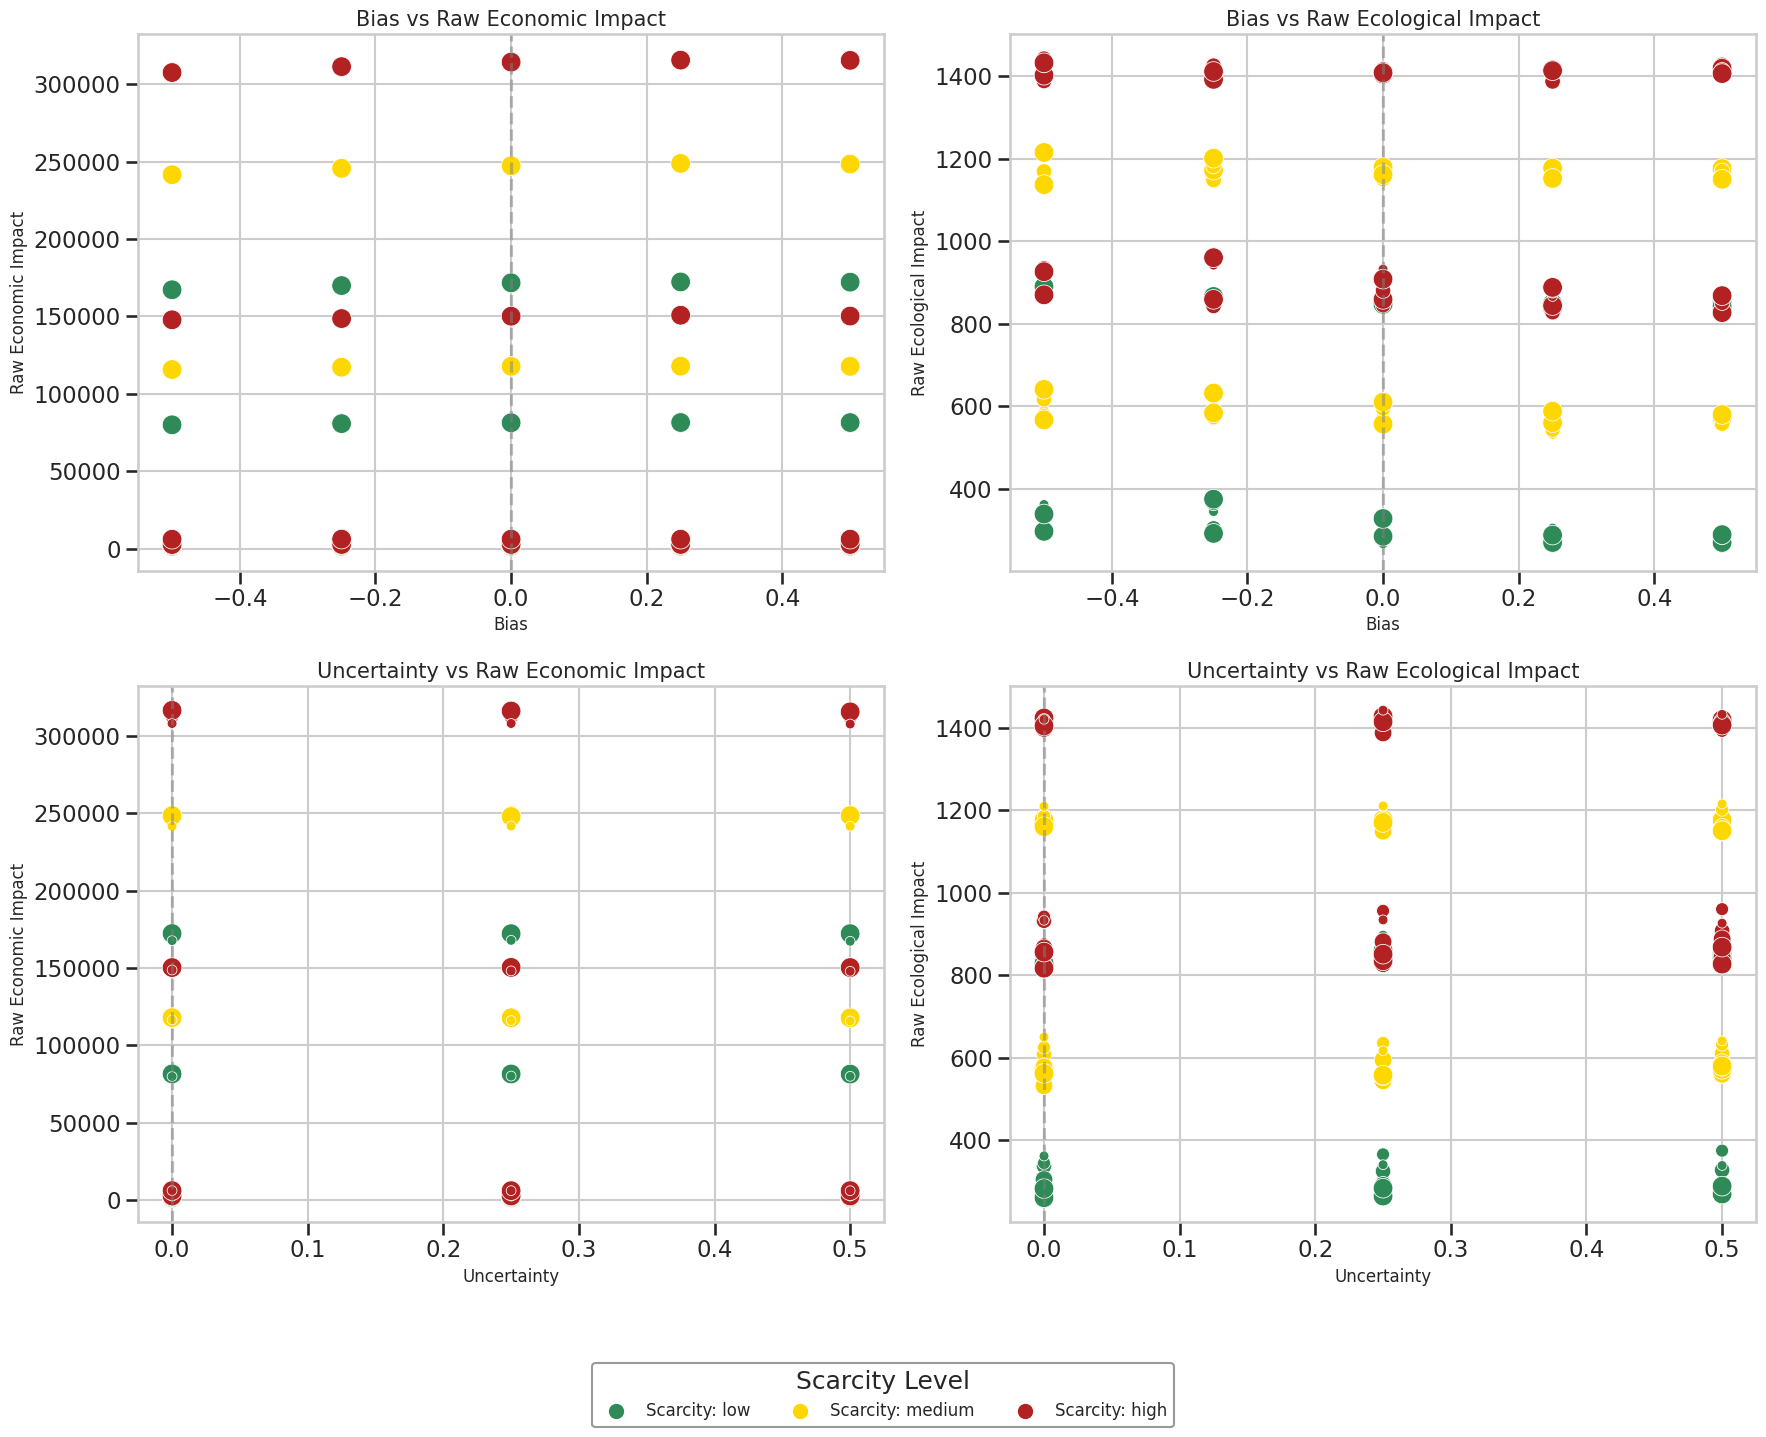

/N/lustre/project/proj-212/Ramtelpp/PersonalProject/Coda3/src/plot_multi_analysis.py:419: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/N/lustre/project/proj-212/Ramtelpp/PersonalProject/Coda3/src/plot_multi_analysis.py:419: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


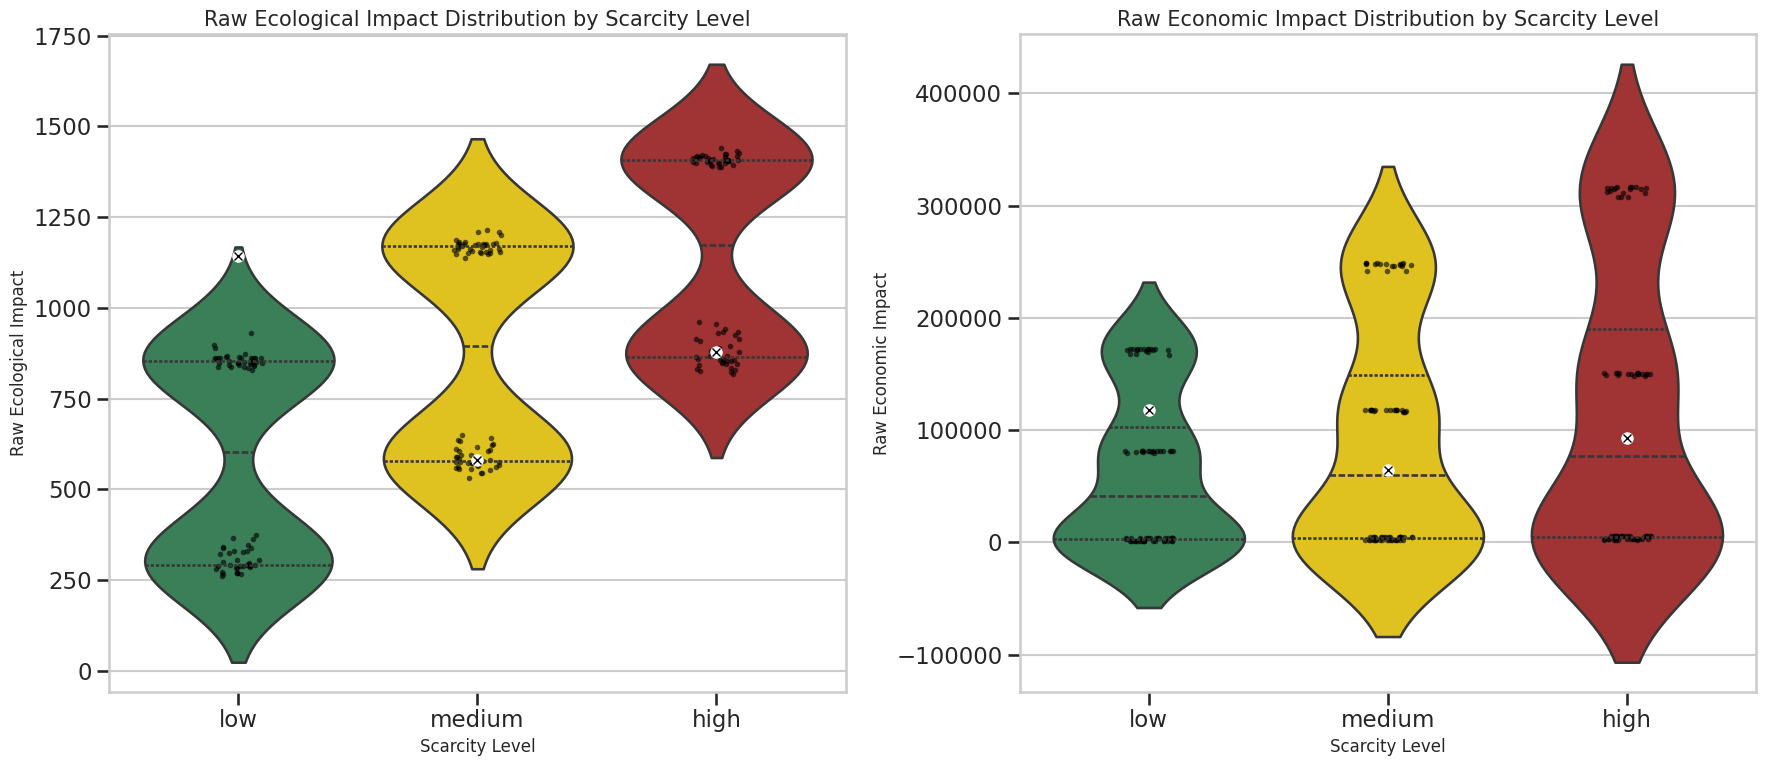

In [10]:
pma.analyze_forecast_effects(results_df)

## Correlation Analysis


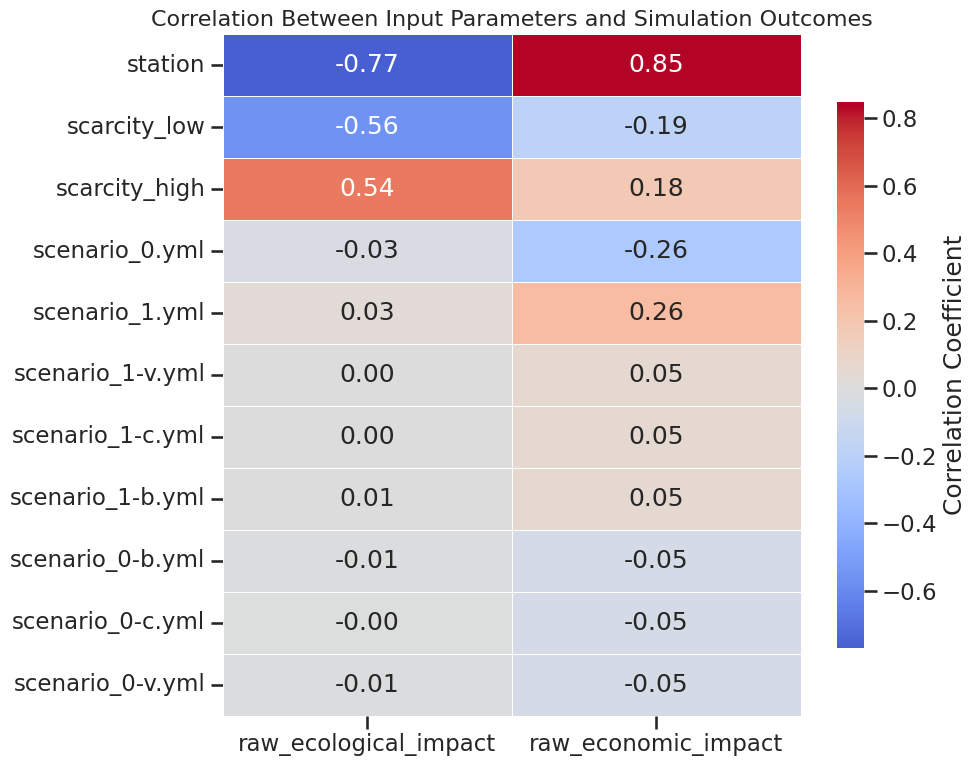


Top impacts on raw_ecological_impact:

Top 5 positive correlations:
  scarcity_high: 0.539
  scenario_1.yml: 0.030
  scarcity_medium: 0.021
  scenario_1-b.yml: 0.005
  scenario_1-v.yml: 0.004

Top 5 negative correlations:
  scenario_0-v.yml: -0.006
  scenario_0.yml: -0.030
  bias: -0.032
  scarcity_low: -0.560
  station: -0.769

Top impacts on raw_economic_impact:

Top 5 positive correlations:
  station: 0.846
  scenario_1.yml: 0.263
  scarcity_high: 0.179
  scenario_1-v.yml: 0.054
  scenario_1-c.yml: 0.054

Top 5 negative correlations:
  scenario_0-v.yml: -0.052
  scenario_0-c.yml: -0.052
  scenario_0-b.yml: -0.053
  scarcity_low: -0.186
  scenario_0.yml: -0.264


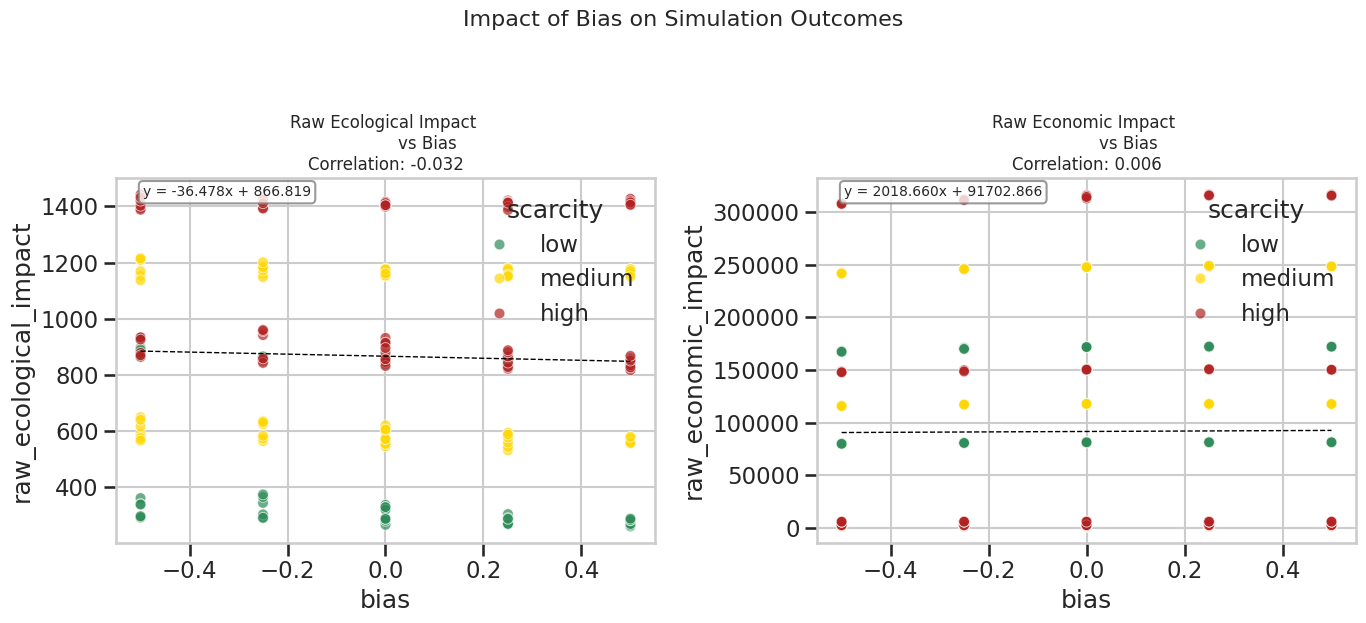

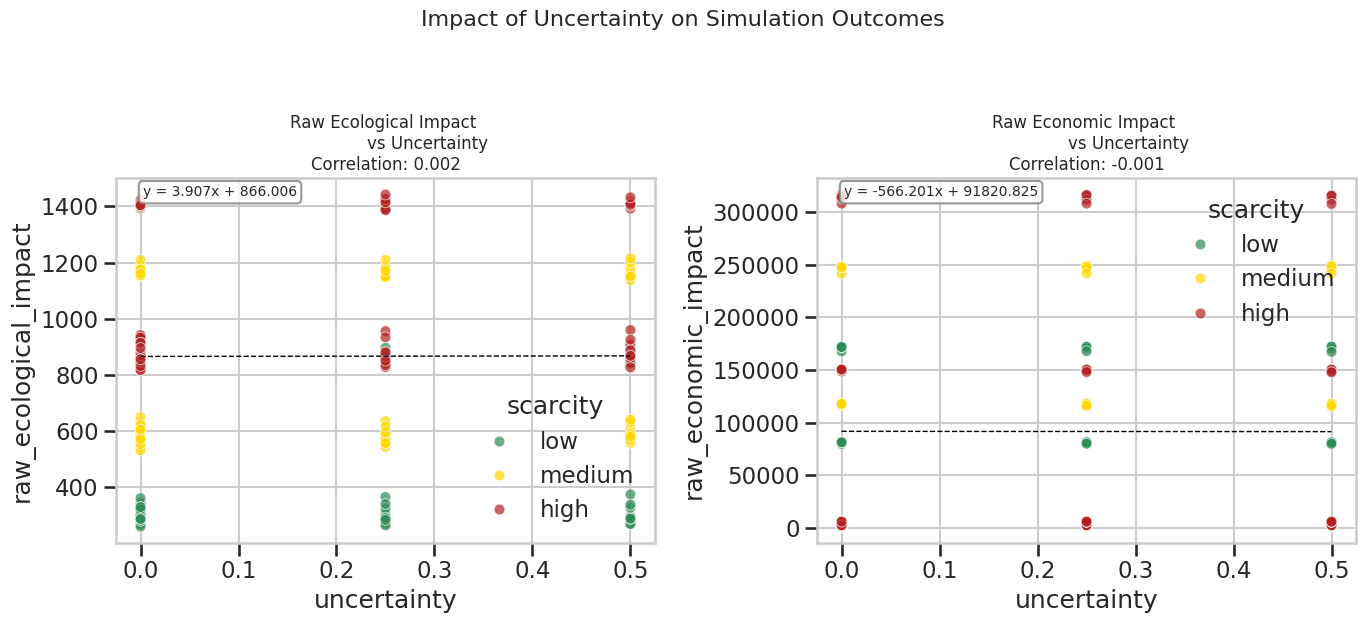

<Figure size 1200x1000 with 0 Axes>

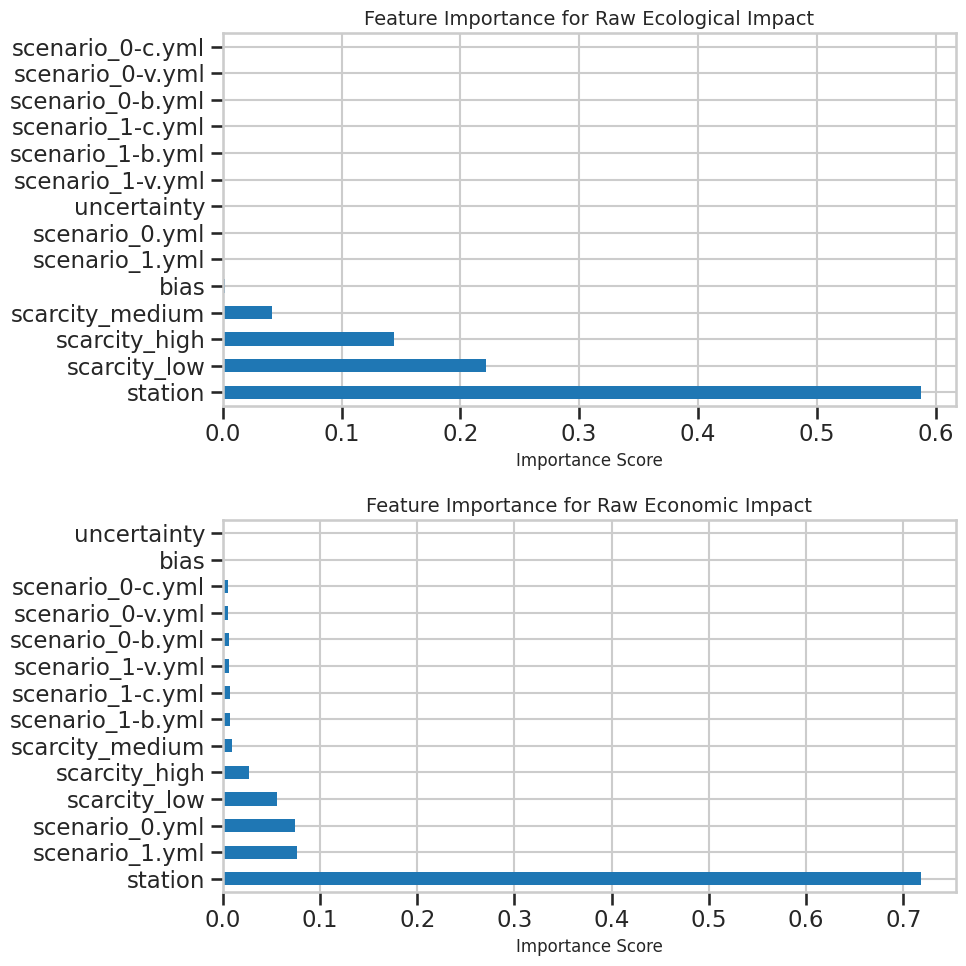

In [11]:
pma.correlation_analysis(results_df)

## Cooperation Analysis
Analyzing cooperation patterns across scenarios and their impact on ecological and economic outcomes.

/N/lustre/project/proj-212/Ramtelpp/PersonalProject/Coda3/src/plot_multi_analysis.py:1168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


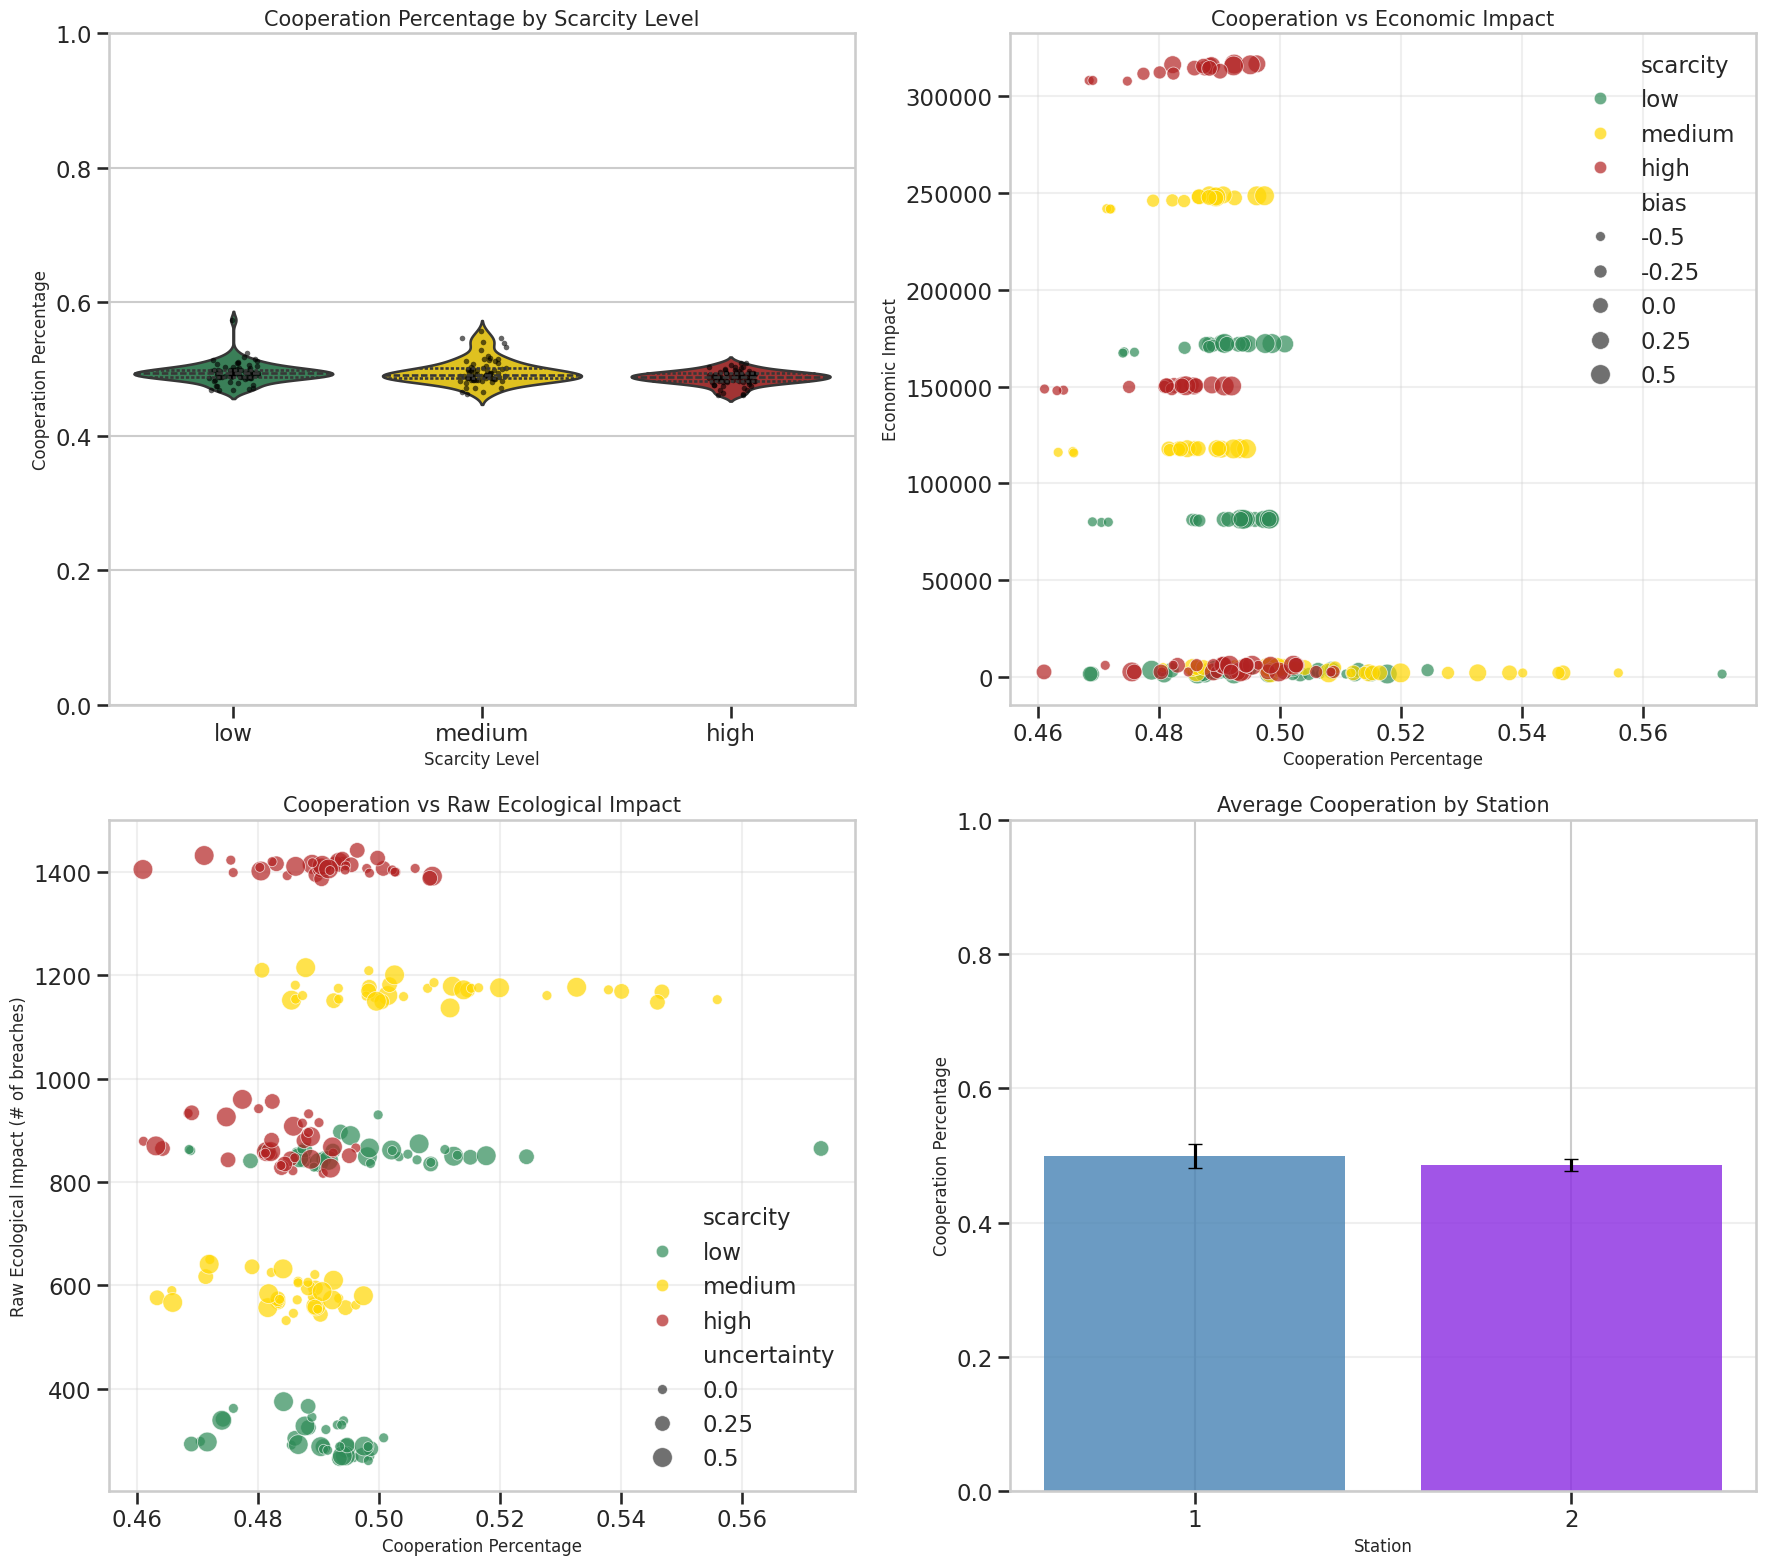

In [12]:
pma.analyze_cooperation_patterns(results_df)

## Raw Impact Vs Scalled Impact
Analyzing the raw (unscaled) ecological / economic impact against scalled impacts 

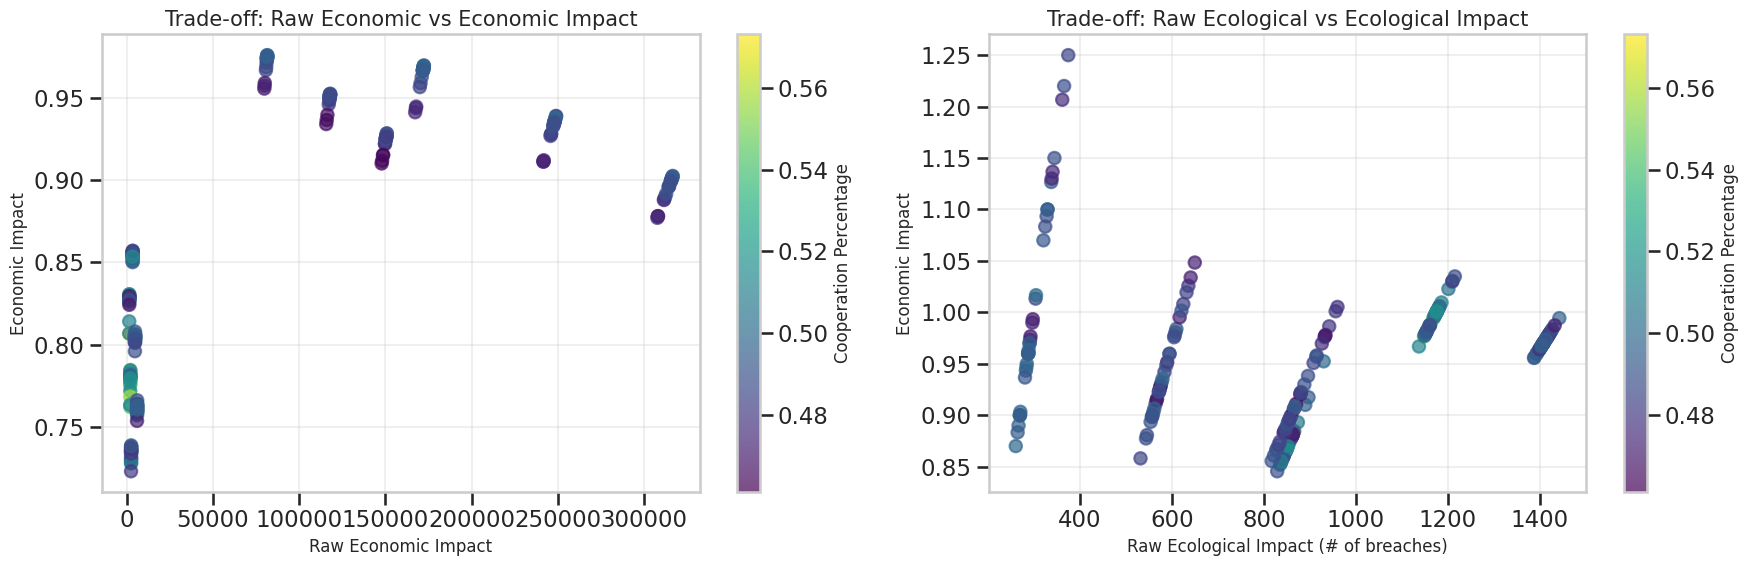

In [13]:
pma.analyze_raw_impact(results_df)

## Cooperation by Forecast Parameters
Analyzing how forecast bias and uncertainty affect cooperation levels.


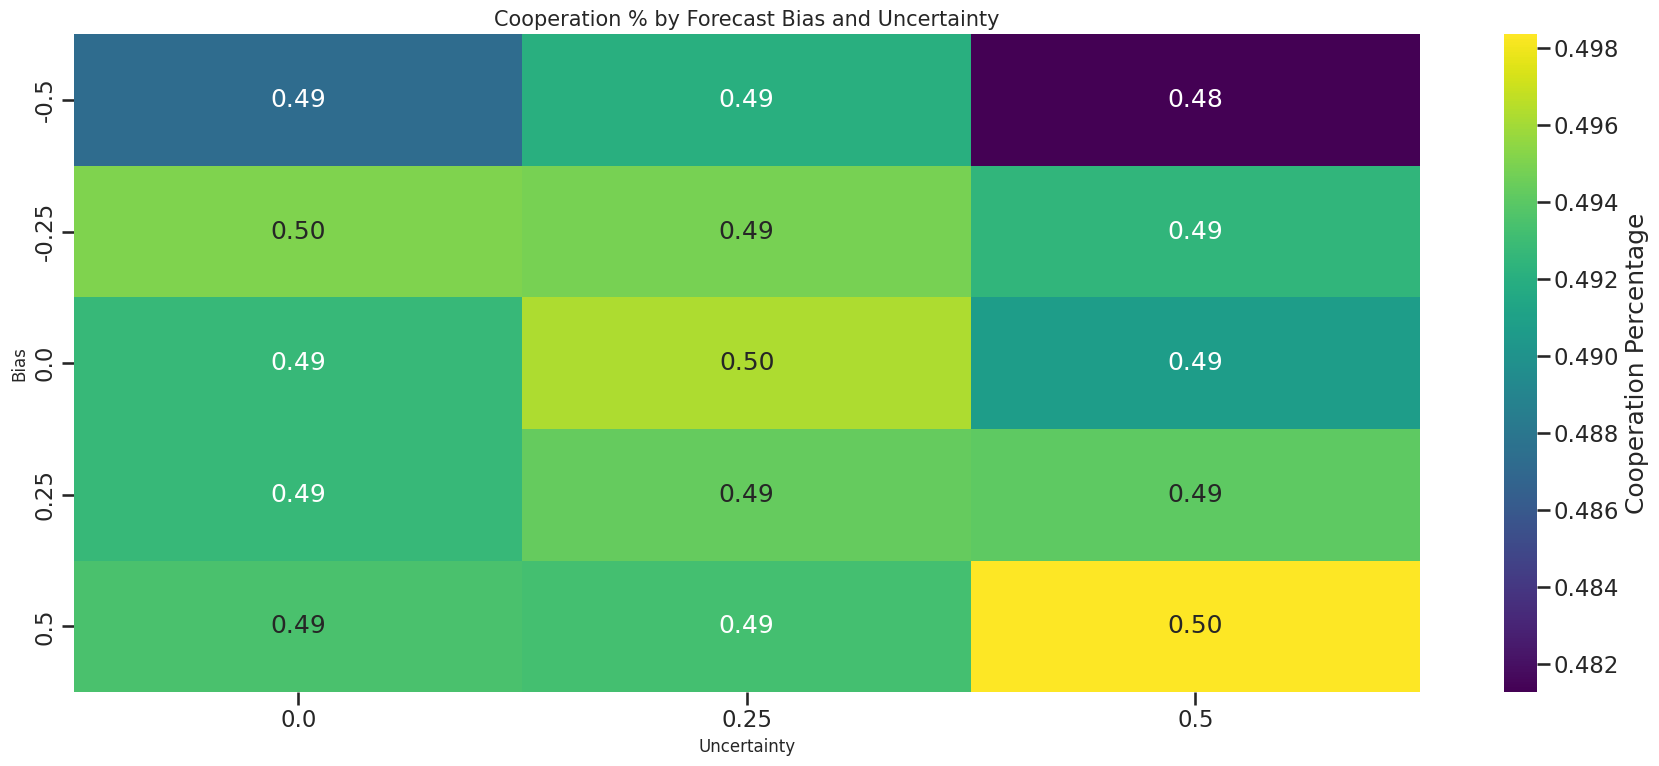

In [14]:
pma.analyze_cooperation_by_forecast_params(results_df)

## Comprehensive Analysis
Performing a comprehensive analysis of all metrics and their relationships.


=== Summary Statistics ===

Overall Metrics:
Average Cooperation: 0.49
Average Raw Ecological Impact: 866.8 breaches
Average Scaled Ecological Impact: 0.952
Average Economic Impact: 91702.866

Correlation Matrix:
                        cooperation_percentage  raw_ecological_impact  \
cooperation_percentage                    1.00                   0.23   
raw_ecological_impact                     0.23                   1.00   
ecological_impact                        -0.04                   0.00   
economic_impact                          -0.35                  -0.94   
raw_economic_impact                      -0.39                  -0.49   
bias                                      0.13                  -0.03   
uncertainty                              -0.02                   0.00   

                        ecological_impact  economic_impact  \
cooperation_percentage              -0.04            -0.35   
raw_ecological_impact                0.00            -0.94   
ecological_impac

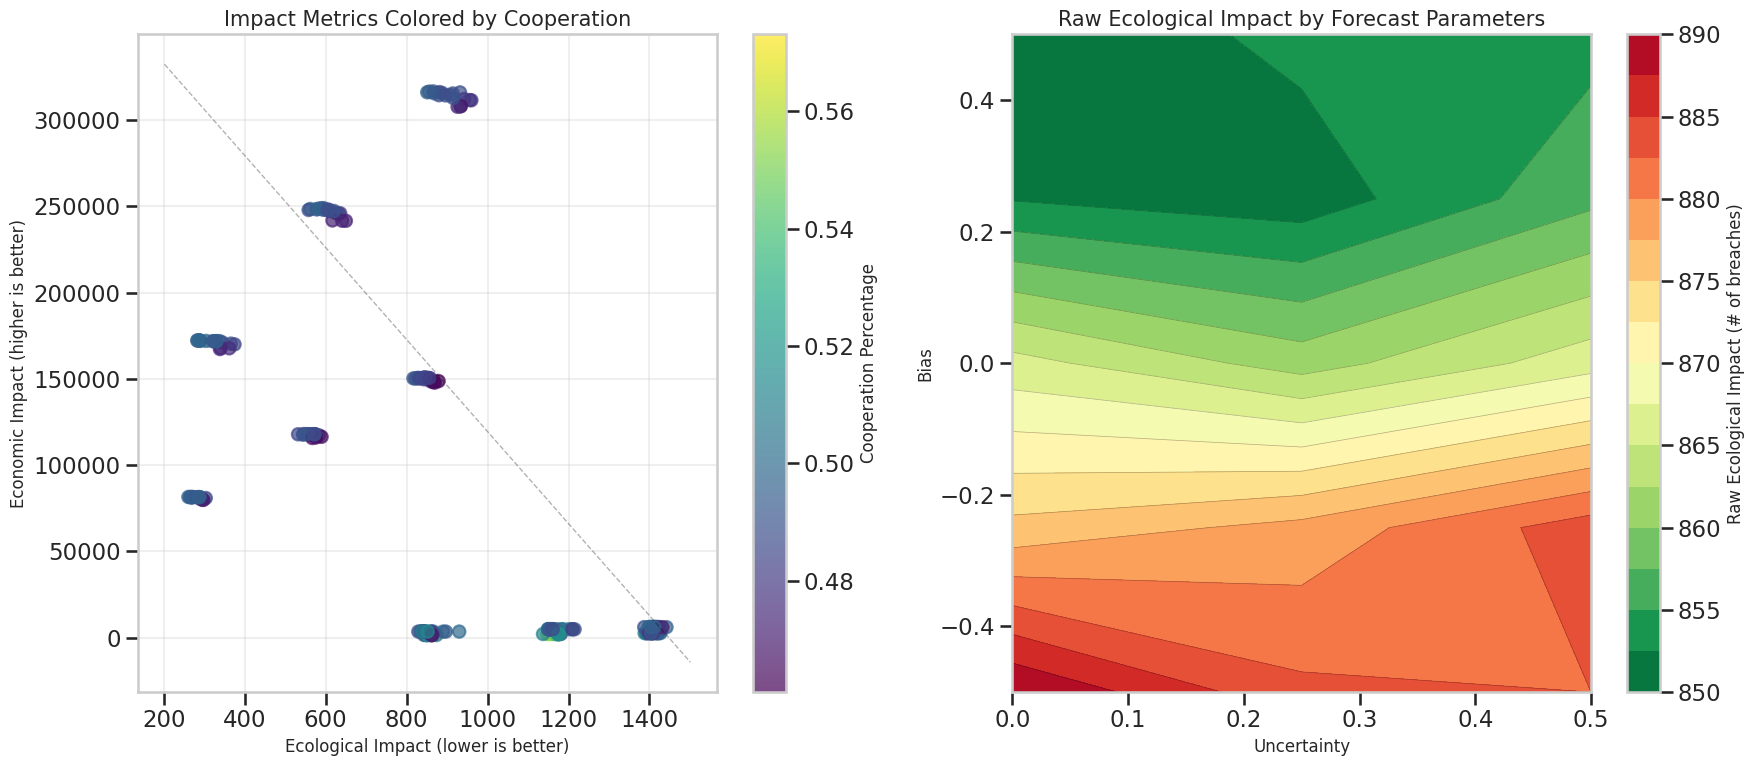

In [15]:
pma.comprehensive_analysis(results_df)

## Conclusion
This notebook has demonstrated how to analyze water allocation policies across multiple scenarios,
focusing on the balance between ecological and economic impacts. To participate in the hackathon:

1. Design your own adaptive policy by modifying the `custom_incentive_policy` and `custom_quota` functions
2. Test your policy across multiple scenarios using the tools provided
3. Optimize your policy to balance ecological integrity and economic benefits

Good luck!